This file takes in the raw BAMWSP data and outputs it in a usable format.

BAMWSP data is a large sample of wells throughout Bangladesh collected in the years up to 2007. We have the village ID, the depth of the well, and its As content.
The raw BAMWSP data do not have lat/lons attached to the wells, or to the village IDs. We have another dataset which gives further information about the villages, which attaches via the village ID. This information includes the county ('mouza') name. We take by-mouza averages as this is the highest granularity we can geocode.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [29]:
wd = '/home/beeb/Insync/sei2112@columbia.edu/Google Drive/Columbia SusDev PhD/Research/My work/predictArsenic/'
os.chdir(wd)
datInpath = 'data/raw/bamwsp/'
wellsPath = datInpath + 'AR_SAMPLESunJun10-14-31-35MDT2007.txt'
villagePath = datInpath + 'villageIDs_Yan.csv'
outpath = 'data/intermediate/bamwsp/villages.csv'

In [6]:
wells = pd.read_csv(wellsPath, header = None, sep = '\t',
                    usecols = [1, 2, 3, 5], dtype = {'villageID': str},
                    names = ['villageID',  'wellDepth', 'wellAs', 'sampleOrigin'],
                   low_memory = False)

In [7]:
village = pd.read_csv(villagePath, dtype = {'Vid': str})

## TASKS:
1. Pre-processing and assertions:
    - BAMWSP data:
        - convert data to correct dtypes
        - check all vids from vilageID present in bamwsp and vice versa
        - check all depths in sensible range
        - check all AS values in sensible range
    - Village data:
        - Drop obs with insufficient data
        - Get unique IDs
        - sense checks
2. Attach bamwsp data to villageIDs
3. Summaries
4. Check Sonargaon data?
    - If not present, read in, assert and concat
5. Sense checks
6. Write out

## Pre-processing and assertions

### BAMWSP data

In [8]:
# convert these strings to numeric and check this does not delete too much data
for colName in ['As', 'Depth']:
    wells['well{}Numeric'.format(colName)] = pd.to_numeric(wells['well{}'.format(colName)], errors = 'coerce')
    assert np.mean(wells['well{}Numeric'.format(colName)].isnull()) < 0.01

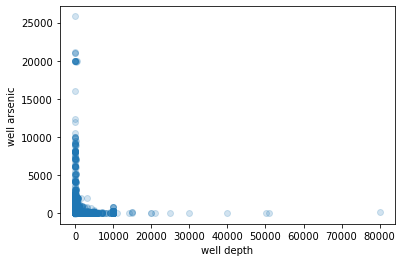

In [9]:
# check that the numeric values of wellAs and wellDepth are sensible
plt.scatter(wells.wellDepthNumeric, wells.wellAsNumeric, alpha = 0.2)
plt.xlabel('well depth')
plt.ylabel('well arsenic')
plt.show()

In [10]:
# more sense checks
for colName in ['As', 'Depth']:
    assert np.mean(wells['well{}Numeric'.format(colName)] < 0) < 0.01
    assert np.mean(wells['well{}Numeric'.format(colName)] > 1000) < 0.01


### Village data

In [11]:
# for any village with an unknown or null mouza, we substitute the village name.
# This may not geocode correctly, but it definitely won't geocode with an unknown 
# mouza, so better than nothing.
village.loc[pd.isnull(village.Mouza), 'Mouza'] = village.loc[pd.isnull(village.Mouza), 'Village']
village.loc[village.Mouza.str.contains('Unknown', case = False) == True, 'Mouza'] = \
    village.loc[village.Mouza.str.contains('Unknown', case = False) == True, 'Village']

# drop any obs where both village and mouza are null
village = village[~pd.isnull(village.Mouza)]

In [12]:
# we drop the village column, as we can't geocode with this much granularity
village = village.drop('Village', axis = 1)

In [13]:
# keep only one line per mouza
village.drop_duplicates(inplace = True)
# make sure that the village IDs are unique
assert village.Vid.value_counts().max() == 1

## Join data

In [14]:
joined = village.merge(wells, left_on = 'Vid', right_on = 'villageID', how = 'outer', validate = '1:m')

In [17]:
unmatchedWells = pd.Series(wells.villageID[~wells.villageID.isin(village.Vid)].unique())

## Outsheet

In [34]:
joined[['villageID', 'District', 'Upazila', 'Union', 'Mouza', 'wellAs']].to_csv(outpath, header = True, index = False)